# Gene prediction targets
Overexpressing essential genes in metabolic pathways is a commonly employed method to enhance the production of a desired molecule. As the increased production of naturally synthesized compounds typically involves genetic modification to metabolic pathways, a crucial initial step is to identify the critical pathways and specific genes to guide strategies for overexpressing or downregulating genes in subsequent manipulations [1].

**Cameo** provides algorithms to search for genes or reactions that can be over or down regulated in order to achieve a given biological objective: Flux Scanning based on Enforced Objective Flux (FSEOF) [2]. 

In [7]:
from cobra.io import read_sbml_model
model = read_sbml_model('/workspaces/group-assingment-group-2/models/modified_model.xml')

In [5]:
from collections.abc import Mapping

In [6]:
from cameo import models
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [10]:
fseof = FSEOF(model)

In [101]:
fseof.run(target=model.reactions.EFE_m)

,1,2,3,4,5,6,7,8,9,10
BIOMASS_Ec_iJO1366_core_53p95M,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372,0.982372
ACCOAC,0.076458,0.076458,0.076458,0.076458,0.076458,0.076458,0.076458,0.076458,0.076458,0.076458
ACGK,0.290578,0.290578,0.290578,0.290578,0.290578,0.290578,0.290578,0.290578,0.290578,0.290578
ACGS,0.290578,0.290578,0.290578,0.290578,0.290578,0.290578,0.290578,0.290578,0.290578,0.290578
ACHBS,0.285408,0.285408,0.285408,0.285408,0.285408,0.285408,0.285408,0.285408,0.285408,0.285408
...,...,...,...,...,...,...,...,...,...,...
UMPK,0.371375,0.371375,0.371375,0.371375,0.371375,0.371375,0.371375,0.371375,0.371375,0.371375
RNTR1c2,0.025705,0.025705,0.025705,0.025705,0.025705,0.025705,0.025705,0.025705,0.025705,0.025705
RNTR2c2,0.026541,0.026541,0.026541,0.026541,0.026541,0.026541,0.026541,0.026541,0.026541,0.026541
RNTR3c2,0.026541,0.026541,0.026541,0.026541,0.026541,0.026541,0.026541,0.026541,0.026541,0.026541


The whole dataframe shows 78 rows, so we can conclude that there are 78 reactions that produce a change of flux.

After running the FSEOF analysis, we can plot the predicted targets that shows an increase or decrease in the flux when the target is set to the last step of the EFE_m reaction.

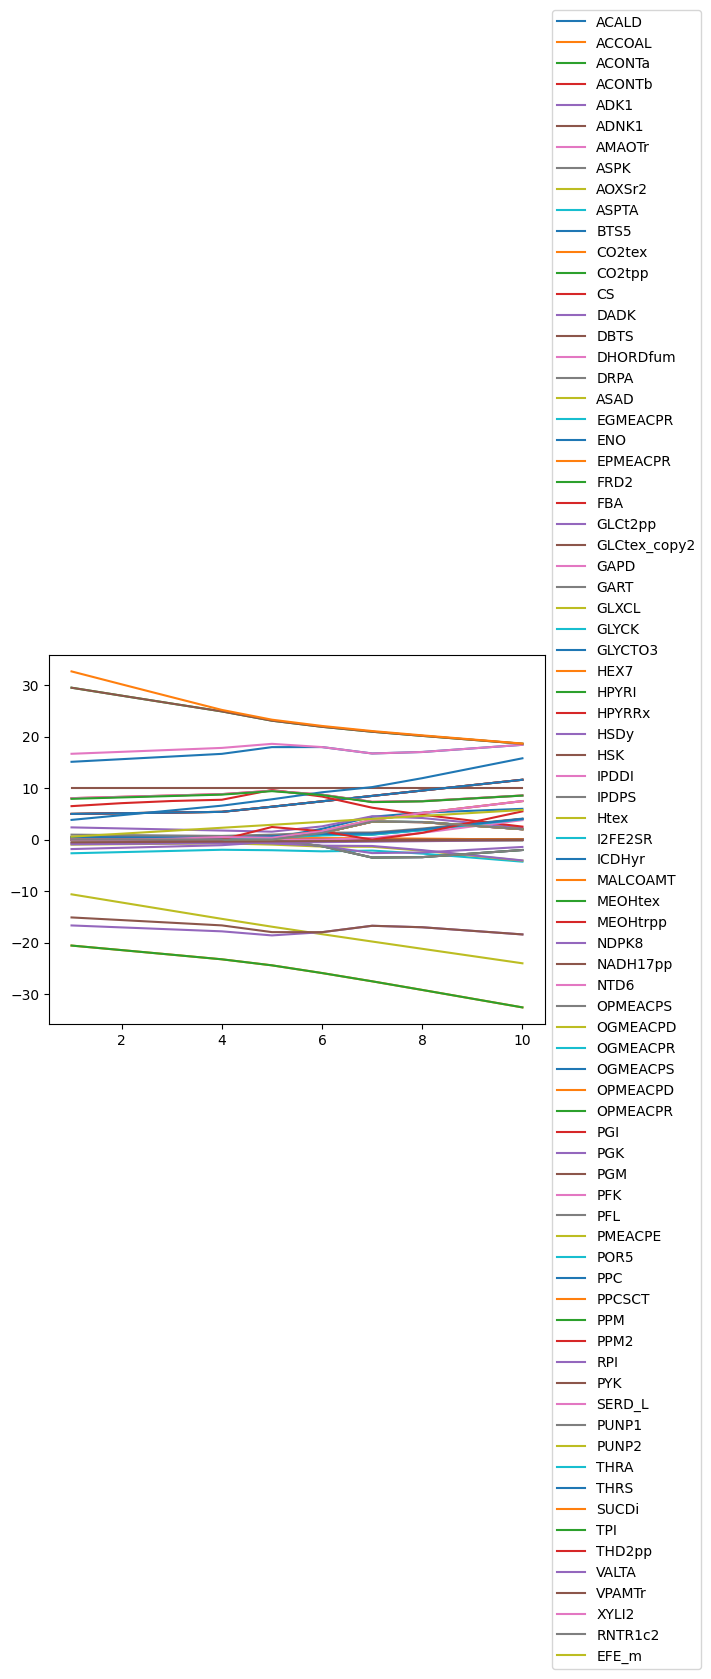

In [13]:
from matplotlib import pyplot as plt
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Next, we can delete all the targets that have a flux change of 0.0, so we can obtain the enzymes that show the highest increase or decrease in flux. :

In [14]:
# sorting the dataframe
df= df.sort_values([1], ascending = False)
 
from pytest import approx
# removing genes from dataframe 
removed_zero = (df != approx(0.0)).all(axis=1)
df = df.loc[removed_zero]
df.head()

,1,2,3,4,5,6,7,8,9,10
SUCDi,32.643705,30.137871,27.646690,25.171221,23.275497,22.057433,21.070909,20.234137,19.437403,18.640668
FRD2,29.478786,27.935192,26.402820,24.882480,23.080876,21.893451,20.938454,20.133785,19.369307,18.604828
NADH17pp,29.478181,27.934639,26.402318,24.882030,23.080484,21.893120,20.938187,20.133582,19.369169,18.604756
GAPD,16.654379,17.033984,17.414922,17.797291,18.586709,17.958945,16.717465,17.004895,17.701099,18.397302
ENO,15.099698,15.612506,16.126940,16.643116,17.948835,17.959111,16.717599,17.004997,17.701167,18.397338


Then, we can plot all of the data in a more representative way, where the genes with a positive change in the flux are represented in green and the ones with a negative change in the flux are shown in red:

/tmp/ipykernel_22549/1924448889.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=90, ha='center')


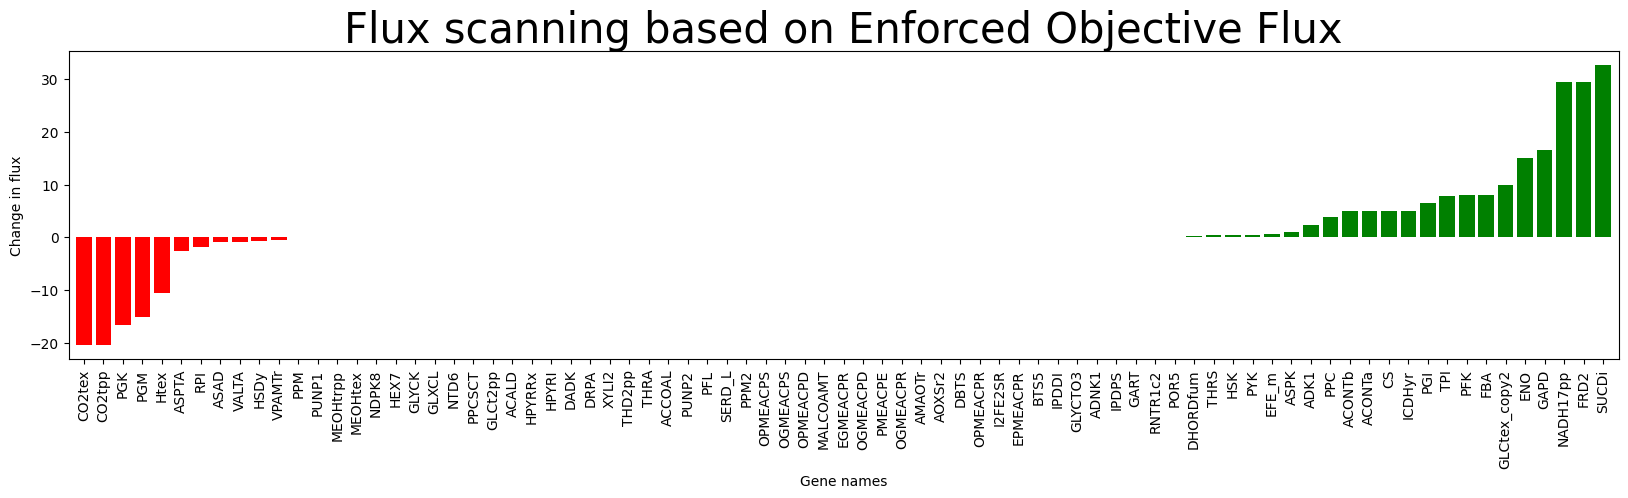

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df.sort_values(by=df.columns[0], ascending=True)

def bar_color(df, color1, color2):
    return np.where(df.values >= 0, color1, color2)

fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(df.index, df[df.columns[0]], color=bar_color(df[df.columns[0]], 'green', 'red'))

ax.set_ylabel('Change in flux')
ax.set_xlabel('Gene names')
ax.set_title('Flux scanning based on Enforced Objective Flux', size=30)

ax.set_xticklabels(df.index, rotation=90, ha='center')
ax.margins(x=0.005)


plt.show()


To see the relative change for the different fluxes we can calculate it as:

R = (B-A) / B +1

In [93]:
df['relative_change_in_flux'] = (df[10]-df[1])/df[10] +1

Then, we can filter the data, selecting the reactions that have a relative change in flux higher than 80%:

In [94]:
target_reactions_df = df[df['relative_change_in_flux'] > 1.8]
target_reactions_df

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
HSDy,-0.631697,-0.577574,-0.523332,-0.468964,-0.748612,-1.168378,-1.235846,-2.038381,-3.037444,-4.036508,1.843504
PPM,-0.000609,-0.000557,-0.000504,-0.000452,-0.000395,-1.275719,-3.481295,-3.399764,-2.706746,-2.013728,1.999698
PUNP1,-0.000609,-0.000557,-0.000504,-0.000452,-0.000395,-1.275719,-3.481295,-3.399764,-2.706746,-2.013728,1.999698
NDPK8,0.000000,0.000000,0.000000,0.000000,0.000000,-1.275386,-3.481026,-3.399560,-2.706608,-2.013655,2.000000
HEX7,-0.000000,0.000000,0.163611,0.502661,0.365838,1.639877,3.805119,5.171160,6.323523,7.475887,2.000000
GLYCK,0.000000,0.000000,0.000000,0.000000,0.000196,0.000165,0.000134,0.000101,0.000069,0.000036,2.000000
GLXCL,0.000000,0.000000,0.000000,0.000000,0.000196,0.000165,0.000134,0.000101,0.000069,0.000036,2.000000
NTD6,0.000000,0.000000,0.000000,0.000000,0.000000,1.275386,3.481026,3.399560,2.706608,2.013655,2.000000
PPCSCT,0.000000,0.000000,0.000000,0.286491,0.308175,0.259659,0.209736,0.158903,0.107827,0.056751,2.000000
GLCt2pp,0.000000,0.000000,0.163611,0.502661,0.365838,1.639877,3.805119,5.171160,6.323523,7.475887,2.000000


And represent this data in a plot:

Text(0.5, 1.0, 'Reactions with a relative change in Flux > 80%')

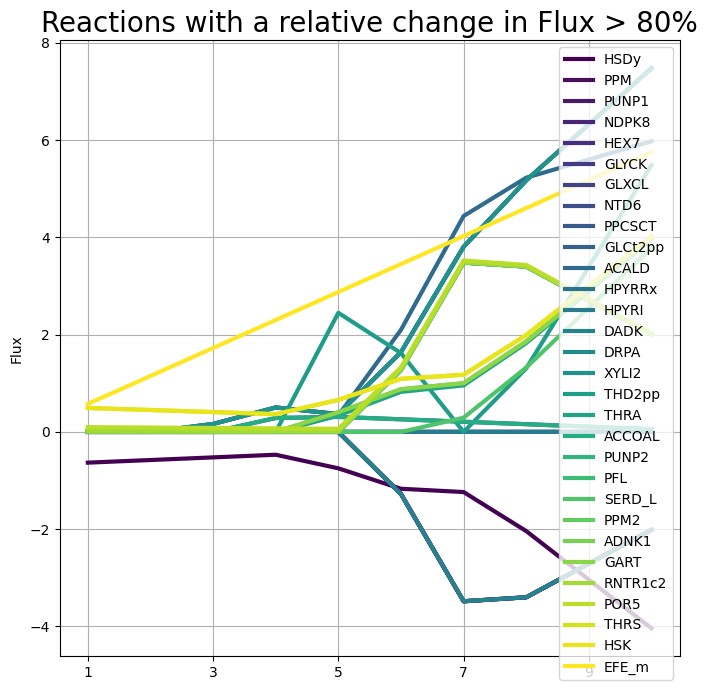

In [89]:
df = target_reactions_df.drop(labels='relative_change_in_flux', axis=1)
fig = df.T.plot(cmap="viridis",figsize=(8, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux')
fig.set_title('Reactions with a relative change in Flux > 80%', size=20)

Finally, from the data that have a relative change in flux higher than 80%, we can obtain a list with the genes that generate the lowest flux reactions and the highest flux reactions:

In [90]:
#lowest flux reactions
target_reactions_df.tail()

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
RNTR1c2,0.023676,0.021648,0.019615,0.017577,0.015364,1.288331,3.491482,3.407482,2.711983,2.016485,1.988259
POR5,0.098406,0.089975,0.081525,0.073056,0.063856,1.329190,3.524485,3.432486,2.728950,2.025415,1.951414
THRS,0.492431,0.450240,0.407957,0.365575,0.658242,1.092235,1.174343,1.991784,3.005825,4.019866,1.877501
HSK,0.492431,0.450240,0.407957,0.365575,0.658242,1.092235,1.174343,1.991784,3.005825,4.019866,1.877501
EFE_m,0.575126,1.150252,1.725377,2.300503,2.875629,3.450755,4.025881,4.601007,5.176132,5.751258,1.900000


In [91]:
#higest flux reactions
target_reactions_df.head()

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
HSDy,-0.631697,-0.577574,-0.523332,-0.468964,-0.748612,-1.168378,-1.235846,-2.038381,-3.037444,-4.036508,1.843504
PPM,-0.000609,-0.000557,-0.000504,-0.000452,-0.000395,-1.275719,-3.481295,-3.399764,-2.706746,-2.013728,1.999698
PUNP1,-0.000609,-0.000557,-0.000504,-0.000452,-0.000395,-1.275719,-3.481295,-3.399764,-2.706746,-2.013728,1.999698
NDPK8,0.000000,0.000000,0.000000,0.000000,0.000000,-1.275386,-3.481026,-3.399560,-2.706608,-2.013655,2.000000
HEX7,-0.000000,0.000000,0.163611,0.502661,0.365838,1.639877,3.805119,5.171160,6.323523,7.475887,2.000000


We can identify all these reactions by doing a search within our model:

In [96]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
model = read_sbml_model('/workspaces/group-assingment-group-2/models/modified_model.xml')

In [97]:
for reaction in model.reactions:
    print(reaction.id, reaction.name)

EX_cm_e Chloramphenicol exchange
EX_cmp_e CMP exchange
EX_co2_e CO2 exchange
EX_cobalt2_e Co2+ exchange
DM_4crsol_c Sink needed to allow p-Cresol to leave system
DM_5drib_c Sink needed to allow 5'-deoxyribose to leave system
DM_aacald_c Sink needed to allow aminoacetaldehyde to leave system
DM_amob_c Sink needed to allow S-Adenosyl-4-methylthio-2-oxobutanoate to leave system
DM_mththf_c Sink needed to allow (2R,4S)-2-methyl-2,3,3,4-tetrahydroxytetrahydrofuran to leave system
EX_colipa_e Core oligosaccharide lipid A exchange
DM_oxam_c Sink needed to allow oxamate to leave system
EX_glc__D_e D-Glucose exchange
EX_glcn_e D-Gluconate exchange
BIOMASS_Ec_iJO1366_WT_53p95M E. coli biomass objective function (iJO1366) - WT - with 53.95 GAM estimate
EX_glcr_e D-Glucarate exchange
EX_colipap_e Core oligosaccharide lipid A diphosphate exchange
EX_glcur_e D-Glucuronate exchange
EX_glcur1p_e D-Glucuronate 1-phosphate exchange
BIOMASS_Ec_iJO1366_core_53p95M E. coli biomass objective function (iJO13

Taking into account lowest and highest flux reactions, we can give a list with the top 10 targets for upregulation:

**HSDy**: Homoserine dehydrogenase (NADPH)

**PPM**: Phosphopentomutase

**PUNP1**: Purine-nucleoside phosphorylase (Adenosine)

**NDPK8**: Nucleoside-diphosphate kinase (ATP:dADP)

**HEX7**: Hexokinase (D-fructose:ATP)

**RNTR1c2**: Ribonucleoside-triphosphate reductase (ATP) (flavodoxin)

**POR5**: Pyruvate synthase

**THRS**: Threonine synthase

**HSK**: Homoserine kinase

**EFE_m**: Ethylene_forming_enzyme_main

#### References
[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5699525/

[2] https://cameo.readthedocs.io/en/latest/06-predict-gene-modulation-targets.html?highlight=fseof